# DeepAR

## Imports and utilities

In [1]:
from os import listdir
from os.path import isfile, join
import os
import io
import json
from time import gmtime, strftime

import pandas as pd
import numpy as np

import boto3

import sagemaker
from sagemaker import get_execution_role
from sagemaker.tuner import HyperparameterTuner
from sagemaker.parameter import IntegerParameter
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import IdentitySerializer

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

In [2]:
print("Pandas version:", pd.__version__)
print("Sagemaker version:", sagemaker.__version__)

Pandas version: 1.1.5
Sagemaker version: 2.31.1


In [3]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = 'crypto-forecasting/deepAR'

We will define a function to load the wanted CSV file

In [4]:
def load_csv_file(file_name, data_path="data/raw", date_col="Date"):
    """
    Loads a CSV file into a dataframe with datetime index.
    :param file_name: the name of the CSV file
    :data_path: the direcotry where the file is stored
    :date_col: the column to be used as datetime index
    """
    data_file = join(data_path, file_name)
    df = pd.read_csv(data_file)
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    return df

In [5]:
bitcoin_data = load_csv_file("coin_Bitcoin.csv")

In [6]:
bitcoin_data.head()

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


## Create Time Series dataset

For creating the training dataset, time series have to be created. To be able to evaluate the model on a test set, we will leave off the last `prediction_lengt` data points of each time series. The [DeepAR](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar_how-it-works.html#deepar_under-the-hood) model automatically creates feature time series and it also automaticaly feeds lagged values. 

In this notebokk, a **yearly data time series** dataset will be created.

The last 573 data points will be left untouched to evaluate the model afterwards and compare it to the linear learner.

In [7]:
training_data = bitcoin_data[:-573]
evaluation_data = bitcoin_data[-573:]

### Create year time series

In [8]:
def make_year_time_series(df, target="Close"):
    """
    Creates time series of the target column with yearly data.
    :param df: The full time data
    :returns: A list of pd.Series(), time series data.
    """
    time_series = []
    
    for year in df.index.year.unique():
        time_series.append(df[str(year)][target])
    
    return time_series

In [9]:
time_series = make_year_time_series(training_data)
print("Total time series: ", len(time_series))

Total time series:  7


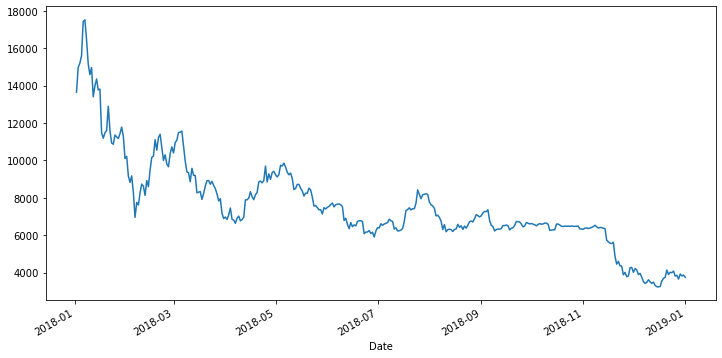

In [10]:
time_series_idx = 5

plt.figure(figsize=(12,6))
time_series[time_series_idx].plot()
plt.show()

### Create training series
Create the training seres by removing the last `prediction_length` of each time sere to be used as training. The hole time series will be used as testing. The DeepAR algorithm will automatically test taking into account the `prediction_length`.

In [11]:
def create_training_series(complete_time_series, prediction_length):
    """
    Given a complete list of time series data, create training time series.
    :param complete_time_series: A list of all complete time series.
    :param prediction_length: The number of points we want to predict.
    :return: A list of training time series.
    """

    time_series_training = []
    
    for ts in complete_time_series:
        time_series_training.append(ts[:-prediction_length])
        
    return time_series_training

In [12]:
prediction_length = 30 # 30 days ~ a month

In [13]:
time_series_training = create_training_series(time_series, prediction_length)

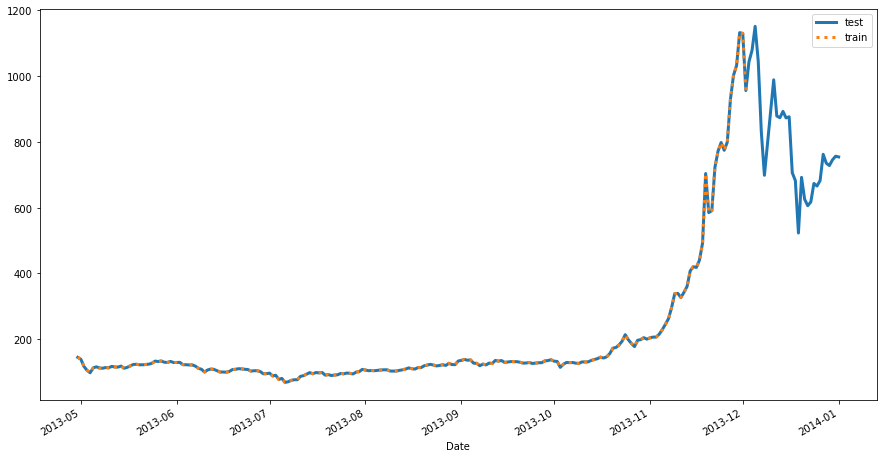

In [14]:
# display train/test time series
time_series_idx = 0

plt.figure(figsize=(15,8))
# test data is the whole time series
time_series[time_series_idx].plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training[time_series_idx].plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

### Convert to JSON and save locally
According to the [DeepAR documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html), DeepAR expects to see input training data in a JSON format, with the following fields:
* **start**: A string that defines the starting date of the time series, with the format 'YYYY-MM-DD HH:MM:SS'.
* **target**: An array of numerical values that represent the time series.
* **cat** (optional): A numerical array of categorical features that can be used to encode the groups that the record belongs to.

In [15]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts)}
    return json_obj

In [16]:
def write_json_dataset(time_series, directory, filename):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    file_path = os.path.join(directory, filename)
    with open(file_path, 'wb') as f:
        for ts in time_series:
            json_line = json.dumps(series_to_json_obj(ts)) + '\n'
            json_line = json_line.encode('utf-8')
            f.write(json_line)
    return file_path

In [17]:
train_local = write_json_dataset(time_series_training, "data/year/", "train.json")        
test_local = write_json_dataset(time_series, "data/year/", "test.json")

In [18]:
print(train_local)
print(test_local)

data/year/train.json
data/year/test.json


### Uploading Data to S3

In [19]:
train_prefix   = '{}/{}/{}'.format(prefix, 'data', 'year')
test_prefix    = '{}/{}/{}'.format(prefix, 'data', 'year')

train_s3 = sagemaker_session.upload_data(train_local, bucket=bucket, key_prefix=train_prefix)
test_s3  = sagemaker_session.upload_data(test_local,  bucket=bucket, key_prefix=test_prefix)

In [20]:
print(train_s3)
print(test_s3)

s3://sagemaker-us-east-1-034143355118/crypto-forecasting/deepAR/data/year/train.json
s3://sagemaker-us-east-1-034143355118/crypto-forecasting/deepAR/data/year/test.json


## Training the DeepAR Estimator

In [85]:
container = sagemaker.image_uris.retrieve('forecasting-deepar', sagemaker_session.boto_region_name)

In [86]:
model_s3_output_path = 's3://{}/{}/model-artifacts/year'.format(bucket, prefix)

# instantiate a DeepAR estimator
deepAR = sagemaker.estimator.Estimator(container,
                                          sagemaker_session=sagemaker_session,
                                          role=role,
                                          instance_count=1,
                                          instance_type='ml.c4.xlarge',
                                          output_path=model_s3_output_path
                                          )

In [87]:
freq='D'
context_length=30 # same as prediction_length

hyperparameters = {
    "epochs": "100",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "early_stopping_patience": "10"
}

deepAR.set_hyperparameters(**hyperparameters)

Hyper-parameter [tunning](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-tuning.html) of the DeepAR estimator

In [90]:
deepAR_hyperparameter_tuner = HyperparameterTuner(estimator = deepAR, 
                                                  objective_metric_name = 'test:RMSE', 
                                                  objective_type = 'Minimize', 
                                                  max_jobs = 20, 
                                                  max_parallel_jobs = 3, 
                                                  hyperparameter_ranges = {
                                                      'epochs': IntegerParameter(100, 500),
                                                      'context_length' : IntegerParameter(30, 60),
                                                      'num_cells': IntegerParameter(40, 50)
                                                  })

In [91]:
tuning_job_name = "tuning-job-year-" + strftime("%Y%m%d-%H%M%S", gmtime())

data_channels = {
    "train": train_s3,
    "test": test_s3
}

deepAR_hyperparameter_tuner.fit(
    inputs=data_channels, 
    job_name=tuning_job_name,
    wait=False
)

Wait until the tuning job is done. We use the argument `wait=False` so the training is not blocking. This way it is possible to keep working with the notebook or come back later when the training is done by using the `tuning_job_name` that can be found in the console.

In [22]:
job_name = "tuning-job-wndw-20210405-172612" # tuning_job_name
deepAR_hyperparameter_tuner = HyperparameterTuner.attach(job_name)

In [23]:
best_training_job = deepAR_hyperparameter_tuner.best_training_job()
print("Best training job: ", best_training_job)

Best training job:  tuning-job-wndw-20210405-172612-008-1c93b187


In [24]:
deepAR_estimator = sagemaker.estimator.Estimator.attach(best_training_job)


2021-04-05 17:46:20 Starting - Preparing the instances for training
2021-04-05 17:46:20 Downloading - Downloading input data
2021-04-05 17:46:20 Training - Training image download completed. Training in progress.
2021-04-05 17:46:20 Uploading - Uploading generated training model
2021-04-05 17:46:20 Completed - Training job completed


In [25]:
deepAR_estimator.hyperparameters()

{'_tuning_objective_metric': 'test:RMSE',
 'context_length': '50',
 'early_stopping_patience': '10',
 'epochs': '284',
 'num_cells': '43',
 'prediction_length': '30',
 'time_freq': 'D'}

## Deploy and Create a Predictor

In [26]:
deepAR_predictor = deepAR_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=IdentitySerializer(content_type="application/json"),
    deserializer=JSONDeserializer()
)

-------------------!

## Make predictions

First we define some functions that will be helpful for encoding and decoding predictions. These functions have been copied from the Udacity Time Series case study.

The DeepAR model uses an [inference](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar-in-formats.html) and response JSON format for the requests.

In [27]:
def json_predictor_input(input_ts, num_samples=50, quantiles=['0.1', '0.5', '0.9']):
    '''Accepts a list of input time series and produces a formatted input.
       :input_ts: A list of input time series.
       :num_samples: Number of samples to calculate metrics with.
       :quantiles: A list of quantiles to return in the predicted output.
       :return: The JSON-formatted input.
       '''
    # request data is made of JSON objects (instances)
    # and an output configuration that details the type of data/quantiles we want
    
    instances = []
    for k in range(len(input_ts)):
        # get JSON objects for input time series
        instances.append(series_to_json_obj(input_ts[k]))

    # specify the output quantiles and samples
    configuration = {"num_samples": num_samples, 
                     "output_types": ["quantiles"], 
                     "quantiles": quantiles}

    request_data = {"instances": instances, 
                    "configuration": configuration}

    json_request = json.dumps(request_data).encode('utf-8')
    
    return json_request

In [28]:
# helper function to decode JSON prediction
def decode_prediction(prediction_data, encoding='utf-8'):
    '''Accepts a JSON prediction and returns a list of prediction data.
    '''
    prediction_list = []
    for k in range(len(prediction_data['predictions'])):
        prediction_list.append(pd.DataFrame(data=prediction_data['predictions'][k]['quantiles']))
    return prediction_list

In [29]:
def get_quantile_predictions(input_ts, target_ts, predictor):
    json_input_ts = json_predictor_input(input_ts)

    # get the prediction from the predictor
    json_prediction = predictor.predict(json_input_ts)

    # get quantiles/predictions
    prediction_list = decode_prediction(json_prediction)
    
    return prediction_list

In [30]:
def display_quantiles(prediction_list, target_ts=None):
    # show predictions for all input ts
    for k in range(len(prediction_list)):
        plt.figure(figsize=(12,6))
        # get the target month of data
        if target_ts is not None:
            target = target_ts[k][-prediction_length:]
            plt.plot(range(len(target)), target, label='target')
        # get the quantile values at 10 and 90%
        p10 = prediction_list[k]['0.1']
        p90 = prediction_list[k]['0.9']
        # fill the 80% confidence interval
        plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
        # plot the median prediction line
        prediction_list[k]['0.5'].plot(label='prediction median')
        plt.legend()
        plt.show()

First, we make predictions on the training data to see how our model is doing.

In [31]:
prediction_list = get_quantile_predictions(time_series_training, time_series, deepAR_predictor)

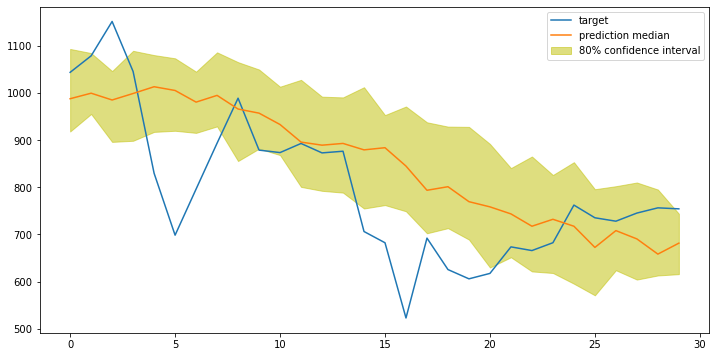

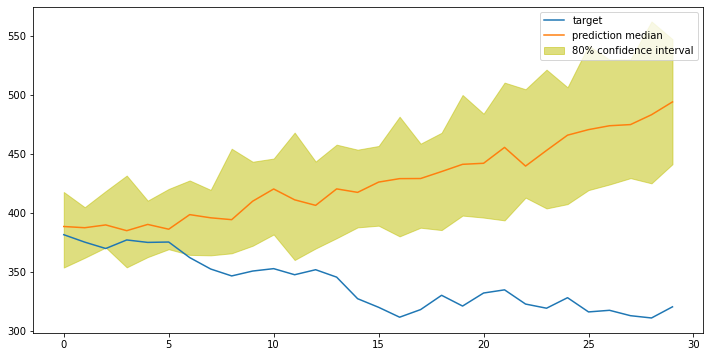

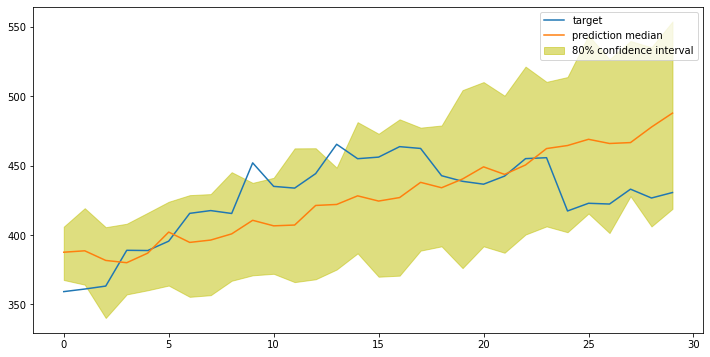

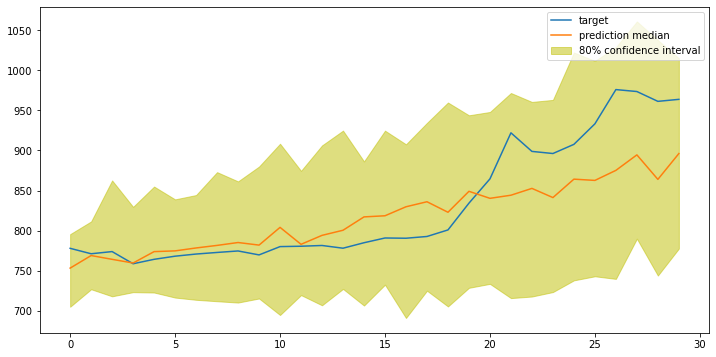

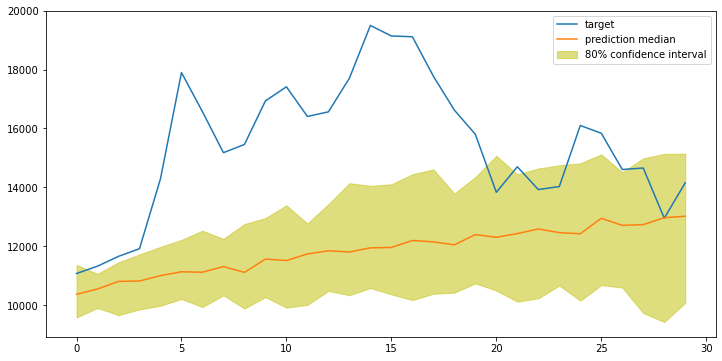

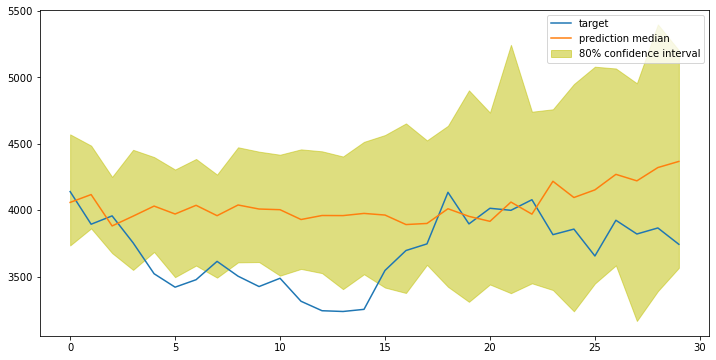

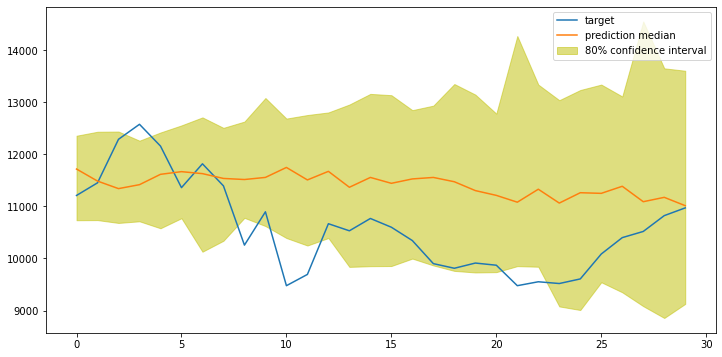

In [32]:
display_quantiles(prediction_list, time_series)

## Forecast evaluation period

Now the model is evauated on the unseen data. 

To have a first glance, we make one prediction of the 30 `prediction_length` first unseen days.

As target data, the previous `context_length` days are used. This parameter has been tuned in the hyper-parameter tuning job.

In [77]:
train_context_length = 50
target_data = training_data["Close"][-train_context_length:]
target = series_to_json_obj(target_data)

request_data = {"instances": [target],
                "configuration": {"num_samples": 50,
                                  "output_types": ["quantiles"],
                                  "quantiles": ['0.1', '0.5', '0.9']}
                }

json_input = json.dumps(request_data).encode('utf-8')

In [78]:
json_prediction = deepAR_predictor.predict(json_input)

prediction = decode_prediction(json_prediction)

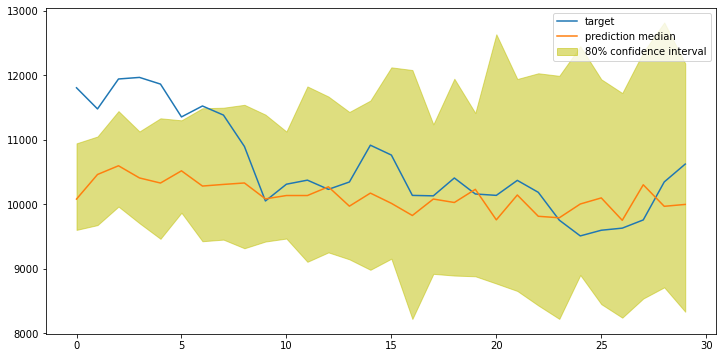

In [79]:
display_quantiles(prediction, [evaluation_data["Close"][:prediction_length]])

### One-step-ahead
To be able to compare this model with the benchmark linear-model, we will generate one-step-ahead predictions. Then we will only take the median and compute the RMSE between the predicted and actual values.

In [80]:
target_data = training_data["Close"]
eval_data = evaluation_data["Close"]

targets = []
for i in range(len(eval_data)):
    target = series_to_json_obj(pd.concat([target_data[-(train_context_length - i):], eval_data[:i]]))
    targets.append(target)
    

In [81]:
len(targets)

573

We make predictions in batches 

In [82]:
def batch_predict(data, predictor, batch=50):
    predictions = []
    
    for target_batch in np.array_split(targets, len(targets)/batch):
        request_data = {"instances": list(target_batch),
                        "configuration": {"num_samples": 50,
                                          "output_types": ["quantiles"],
                                          "quantiles": ['0.1', '0.5', '0.9']}
                        }

        json_input = json.dumps(request_data).encode('utf-8')

        json_prediction = predictor.predict(json_input)

        prediction = decode_prediction(json_prediction)

        predictions = predictions + [p["0.5"][0] for p in prediction]
    
    return predictions

In [83]:
one_step = batch_predict(targets, deepAR_predictor) 

In [84]:
len(one_step)

573

In [85]:
def one_step_ahead_graph(actual, forecast):
    print('One-step-ahead RMSE = ', np.sqrt(mean_squared_error(actual, forecast)))
    plt.figure(figsize=(20,10))
    plt.plot(actual, label='actual')
    plt.plot(forecast, label='forecast')
    plt.legend()
    plt.show()

One-step-ahead RMSE =  1413.6709448718364


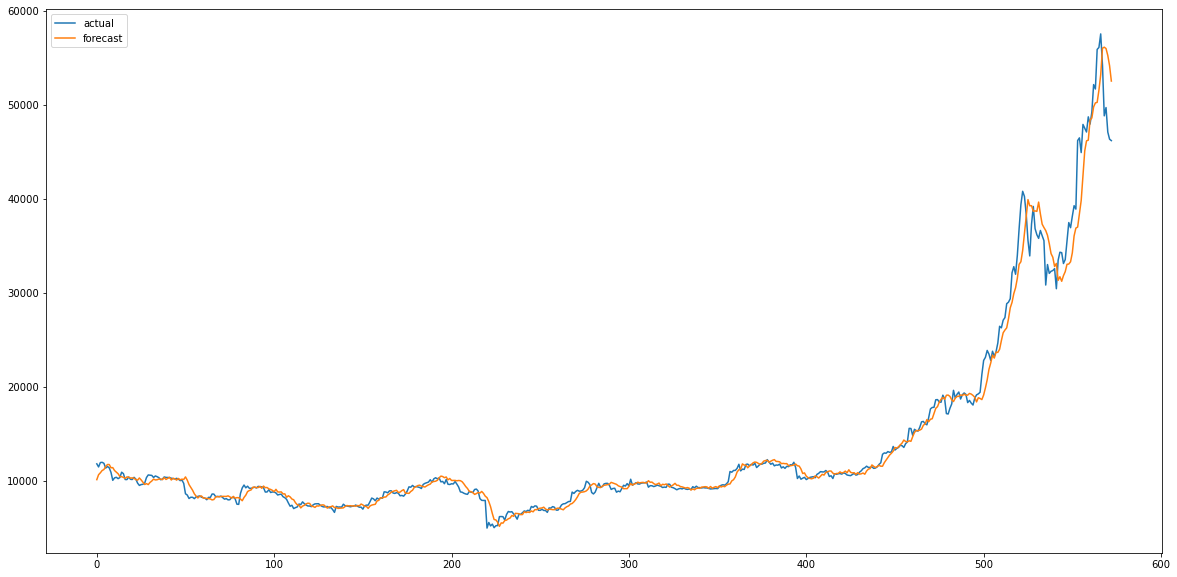

In [86]:
one_step_ahead_graph(eval_data.to_numpy(), one_step)

## Clean up

Remember to delete running endpoints and notebook instances.

In [88]:
deepAR_predictor.delete_endpoint()